# Exploratory Data Analysis (EDA)

Summarize the characteristics of the tree trims dataset, identify important variables and plot the data to uncover patterns and identify outliers. Evaluate the dataset to determine which forecasting models to fit to the data.

**Project Notebooks Execution Order**
* [1-data-wrangling-optimize-verify.ipynb](1-data-wrangling-optimize-verify.ipynb)
* [2-data-wrangling-deduplicate.ipynb](2-data-wrangling-deduplicate.ipynb)
* 3-exploratory-data-analysis.ipynb
* [4-forecasting-opened-requests.ipynb](4-forecasting-opened-requests.ipynb)
* [5-forecasting-closed-requests.ipynb](5-forecasting-closed-requests.ipynb)
* [6-summary.ipynb](6-summary.ipynb)

For a full explanation of this project, see the `README.md` file at the project root or the `6-summary.ipynb` notebook.

# Import Packages and Modules

In [1]:
import os

from cycler import cycler
from IPython.core.interactiveshell import InteractiveShell
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import register_matplotlib_converters
import statsmodels.api as sm
from scipy import stats

# Settings

Configure settings for notebook, plots, files and environmental variables. Set `ast_node_interactivity` to display the output of all expressions in a cell so that more than one data frame can be printed at a time in a single cell. Semicolons at the end of `plt.show();` are used in this notebook to suppress the printing of matplotlib objects in cell outputs. Load functions called in notebook.

In [2]:
# Notebook settings
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline
register_matplotlib_converters()

# Plot settings
alpha_mpl = 0.75
color_cycle = ['dodgerblue', '#d5019a', 'midnightblue', 'gray']
plt.style.use('seaborn-darkgrid')
mpl.rcParams['figure.titlesize'] = 18
mpl.rcParams['axes.prop_cycle'] = cycler(color=color_cycle)
mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11
mpl.rcParams['legend.fontsize'] = 11

# File settings
data_raw = os.path.abspath('./data/raw/')
data_interim = os.path.abspath('./data/interim/')
data_processed = os.path.abspath('./data/processed/')

# Import preprocessing functions
%run preprocess_data.py

# Load and Split Data

In [3]:
df_tt = read_data(
    'Chicago Tree Trims',
    data_processed,
    'chicago-tree-trims.pkl',
)

Chicago Tree Trims
<class 'pandas.core.frame.DataFrame'>
Int64Index: 295577 entries, 118 to 360482
Data columns (total 13 columns):
creation_date_dt           295577 non-null datetime64[ns]
completion_date_dt         287211 non-null datetime64[ns]
status                     295577 non-null category
service_request_number     295577 non-null object
type_of_service_request    295577 non-null category
location_of_trees          181848 non-null category
street_address             295577 non-null object
zip_code                   295577 non-null int64
community_area             295577 non-null int64
latitude                   295485 non-null float64
longitude                  295485 non-null float64
location                   295485 non-null object
is_duplicate               295577 non-null bool
dtypes: bool(1), category(3), datetime64[ns](2), float64(2), int64(2), object(3)
memory usage: 83.0 MB
None




Split the dataset into training and test sets where the counts of opened and closed tree trim requests are aggregated by month. Leave the test set out of EDA so that the it is only used only to test the model and is not involved in selecting the model parameters or the models. The test set should include the last 12 months of data so that one full seasonal cycle is included in the set. Ideally the test set should include more data. However, once the dataset is grouped by month, the number of observations in the training and test sets shrinks and the training set needs several cycles of seasonal data in order to forecast accurately.

In [4]:
df_o_train_has_dupe, df_o_test_has_dupe = split_train_test(
    df_tt,
    'creation_date_dt',
    no_dupe=False,
)
df_c_train_has_dupe, df_c_test_has_dupe = split_train_test(
    df_tt,
    'completion_date_dt',
    no_dupe=False,
)
df_o_train_no_dupe, df_o_test_no_dupe = split_train_test(
    df_tt,
    'creation_date_dt',
    no_dupe=True,
)
df_c_train_no_dupe, df_c_test_no_dupe = split_train_test(
    df_tt,
    'completion_date_dt',
    no_dupe=True,
)

# Describe Data

## Non-Aggregated Tree Trims Data

Review the head, tail and a sample of the unaggregated dataset to verify the data was read in correctly.

In [5]:
df_tt.head(3)
df_tt.sample(3)
df_tt.tail(3)

,creation_date_dt,completion_date_dt,status,service_request_number,type_of_service_request,location_of_trees,street_address,zip_code,community_area,latitude,longitude,location,is_duplicate
118,2010-03-03,2012-04-19,Completed,10-00273410,Tree Trim,Parkway,1520 N KILDARE AVE,60651,23,41.908234,-87.733832,"(41.908234021259, -87.73383192869)",False
119,2010-04-01,2011-04-21,Completed,10-00423206,Tree Trim,Parkway,5002 S CORNELL AVE,60615,39,41.804296,-87.586481,"(41.804295950175, -87.586481283194)",False
120,2010-04-01,2011-04-22,Completed,10-00423211,Tree Trim,Parkway,4940 S EAST END AVE,60615,39,41.805210,-87.586067,"(41.805210450949, -87.586067495876)",False


,creation_date_dt,completion_date_dt,status,service_request_number,type_of_service_request,location_of_trees,street_address,zip_code,community_area,latitude,longitude,location,is_duplicate
239146,2015-10-16,2016-01-30,Completed,15-05419022,Tree Trim,Parkway,7728 S OGLESBY AVE,60649,43,41.754833,-87.567508,"(41.754833038325, -87.567507566879)",False
175466,2014-07-23,2015-08-31,Completed,14-01181418,Tree Trim,Parkway,5001 S LAPORTE AVE,60638,56,41.802079,-87.746678,"(41.802078971901, -87.746677583314)",False
32594,2011-07-01,2013-11-04,Completed,11-03287073,Tree Trim,Parkway,2454 N KEDZIE BLVD,60647,22,41.926390,-87.707267,"(41.926389526608, -87.707266631587)",False


,creation_date_dt,completion_date_dt,status,service_request_number,type_of_service_request,location_of_trees,street_address,zip_code,community_area,latitude,longitude,location,is_duplicate
360480,2018-10-31,NaT,Open,18-03054374,Tree Trim,Parkway,8645 S CHAMPLAIN AVE,60619,44,41.737593,-87.608554,"(41.737593240632, -87.608553778799)",False
360481,2018-10-31,2018-11-05,Completed,18-03054475,Tree Trim,Parkway,513 N CLAREMONT AVE,60612,24,41.890871,-87.685477,"(41.890870904361, -87.685477035683)",False
360482,2018-10-31,2018-12-04,Completed,18-03054564,Tree Trim,Parkway,10335 S AVENUE O,60617,52,41.707556,-87.540125,"(41.707556424485, -87.540125307911)",False


Verify the type of service request is limited to tree trims.

In [6]:
df_tt['type_of_service_request'].value_counts().to_frame('value_counts')

,value_counts
Tree Trim,295577


How many duplicate Service Request Numbers are there in the dataset?

In [7]:
print(
    'Number of duplicate Service Request Numbers: {}'
    .format(df_tt['is_duplicate'].sum())
)

Number of duplicate Service Request Numbers: 975


Review the range of values for opened request and closed request dates. Look for unusual or surprising variations in the data that might indicate problems with the values in the dataset.

In [8]:
df_tt[['creation_date_dt', 'completion_date_dt']].describe()

,creation_date_dt,completion_date_dt
count,295577,287211
unique,3104,2062
top,2011-07-11 00:00:00,2013-10-15 00:00:00
freq,515,939
first,2010-03-03 00:00:00,2011-01-03 00:00:00
last,2018-10-31 00:00:00,2018-12-18 00:00:00


What are the value counts for categorical variables?

In [9]:
df_tt['status'].value_counts().to_frame('value_count')

df_tt['type_of_service_request'].value_counts().to_frame('value_count')

df_tt['location_of_trees'].value_counts().to_frame('value_count')

df_tt['is_duplicate'].value_counts().to_frame('value_count')

,value_count
Completed,287211
Open,8366
Open - Dup,0
Completed - Dup,0


,value_count
Tree Trim,295577


,value_count
Parkway,173741
Alley,4443
Vacant Lot,3664


,value_count
False,294602
True,975


The unaggregated and pre-split data doesn't display any issues with reading the data into the notebook. From this point forward, only use the training datasets to keep the test data from leaking information that might influence the choice of model parameters and the models.

## Aggregated Tree Trims Data

Review the head, tail and a sample of the aggregated test sets.

In [10]:
df_o_train_has_dupe.head(3)
df_o_train_has_dupe.sample(3)
df_o_train_has_dupe.tail(3)

,count
creation_date_dt,
2010-03-01,1
2010-04-01,479
2010-05-01,916


,count
creation_date_dt,
2013-04-01,2621
2016-09-01,3912
2012-02-01,1278


,count
creation_date_dt,
2017-08-01,6629
2017-09-01,3178
2017-10-01,3006


In [11]:
df_c_train_has_dupe.head(3)
df_c_train_has_dupe.sample(3)
df_c_train_has_dupe.tail(3)

,count
completion_date_dt,
2011-01-01,1470
2011-02-01,920
2011-03-01,2368


,count
completion_date_dt,
2013-03-01,3394
2011-09-01,1198
2013-12-01,2882


,count
completion_date_dt,
2017-08-01,4656
2017-09-01,4772
2017-10-01,3434


What is the range of values for the aggregated tree trims training data? Are there any differences between the training sets with and without duplicates?

In [12]:
pd.concat(
    [
        df_o_train_has_dupe
        .describe()
        .rename({'count': 'Opened Requests Has Dupes'}, axis='columns'),
        df_o_train_no_dupe
        .describe()
        .rename({'count': 'Opened Requests No Dupes'}, axis='columns'),
    ], axis='columns')

pd.concat(
    [
        df_c_train_has_dupe
        .describe()
        .rename({'count': 'Closed Requests Has Dupes'}, axis='columns'),
        df_c_train_no_dupe
        .describe()
        .rename({'count': 'Closed Requests No Dupes'}, axis='columns'),
], axis='columns')

,Opened Requests Has Dupes,Opened Requests No Dupes
count,92.000000,92.000000
mean,2845.402174,2835.076087
std,1808.535028,1798.011962
min,1.000000,1.000000
25%,1329.000000,1328.750000
50%,2339.000000,2332.000000
75%,4045.500000,4019.500000
max,6663.000000,6627.000000


,Closed Requests Has Dupes,Closed Requests No Dupes
count,82.000000,82.000000
mean,3066.902439,3055.451220
std,1694.918867,1686.176471
min,220.000000,220.000000
25%,1993.750000,1991.250000
50%,2880.500000,2874.500000
75%,3930.500000,3897.250000
max,9157.000000,9150.000000


There are some rather high maximum values in the 6000 or 9000 range of requests per month. The differences between the sets with and without duplicates is minimal.

# Data Variation

Plot the distributions of the request counts per month.

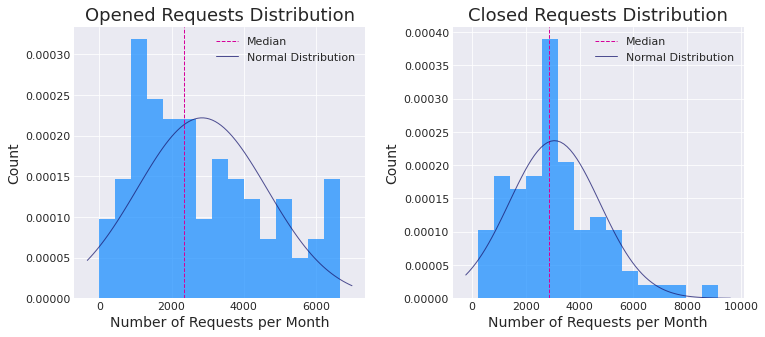

In [13]:
dfs = [
    [df_o_train_has_dupe, 'Opened Requests'],
    [df_c_train_has_dupe, 'Closed Requests']
]

line_width = 1

fig, ax = plt.subplots(figsize=(12, 5))
fig.subplots_adjust(wspace=0.3)

for idx, df in enumerate(dfs):
    
    x = df[0]['count']
 
    ax = plt.subplot(1, 2, idx+1)
    ax.hist(x, bins=15, density=True, alpha=alpha_mpl)
    ax.axvline(
        np.median(x), 
        color='C1', 
        linestyle='--', 
        linewidth=line_width,
        label='Median',
    )

    mu, std = stats.norm.fit(x)
    x_min, x_max = ax.get_xlim()
    x_pdf = np.linspace(x_min, x_max, len(x))
    pdf = stats.norm.pdf(x_pdf, mu, std)
    
    ax.plot(
        x_pdf, 
        pdf, 
        linewidth=line_width, 
        color='C2', 
        alpha=alpha_mpl,
        label='Normal Distribution',
    )

    ax.set_xlabel('Number of Requests per Month')
    ax.set_ylabel('Count')
    ax.set_title('{} Distribution'.format(df[1]))
    ax.legend()

plt.show();

Both distributions exhibit a right skew and are not normally distributed, though the closed requests are closer to the normal distribution than the opened requests.

Check the normality of the opened requests and closed requests using a probability plot. It plots sample data from the input distribution against the quantiles of the normal distribution and fits a least-squares regression line to the sample data.

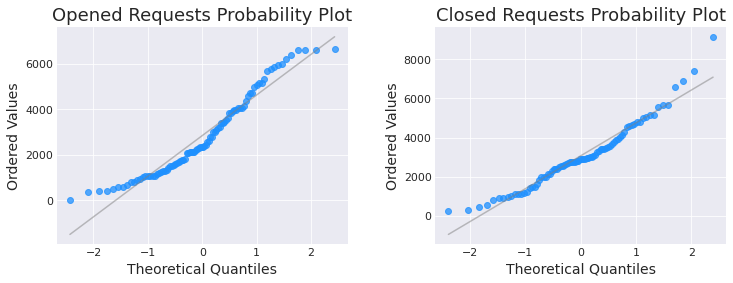

In [14]:
fig, ax = plt.subplots(figsize=(12, 4))
fig.subplots_adjust(wspace=0.3)

for idx, df in enumerate(dfs):

    x = df[0]['count']
    (osm, osr), (slope, intercept, r) = stats.probplot(x, dist='norm', 
                                                       fit=True)
    
    ax = plt.subplot(1, 2, idx+1)
    ax.plot(
        osm, 
        osr, 
        marker='o', 
        markerfacecolor='C0', 
        markeredgecolor='C0',
        alpha=0.75, 
        linestyle=''
    )
    ax.plot(osm, (slope*osm + intercept), color='C3', alpha=0.5)

    ax.set_xlabel('Theoretical Quantiles')
    ax.set_ylabel('Ordered Values')
    ax.set_title('{} Probability Plot'.format(df[1]))

plt.show();

The opened requests data exhibits an elongated s-curve does that does not follow the normal distribution. The data in the closed requests is relatively close to normal, with some wiggle in the tails.  

# Correlation

Is there a relationship between opened requests and closed requests per month?

In [15]:
(
    pd.concat(
        [
            df_o_train_has_dupe
            .rename({'count': 'Opened Requests'}, axis='columns'),
            df_c_train_has_dupe
            .rename({'count': 'Closed Requests'}, axis='columns'),
        ], axis='columns')
    .dropna()
    .astype(int)
    .corr()
)

,Opened Requests,Closed Requests
Opened Requests,1.000000,0.446657
Closed Requests,0.446657,1.000000


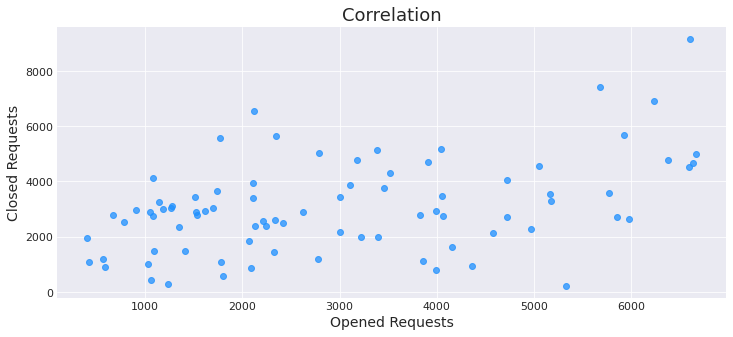

In [16]:
x = df_o_train_has_dupe.loc[df_o_train_has_dupe.index > '2010-12-31']['count']
y = df_c_train_has_dupe['count']

fig, ax = plt.subplots(figsize=(12, 5))

ax.scatter(x, y, alpha=alpha_mpl)

ax.set_xlabel('Opened Requests')
ax.set_ylabel('Closed Requests')
ax.set_title('Correlation')

plt.show();

There is a weak positive relationship between opened requests and closed requests per month.

What is the total number of opened requests and closed requests per month and per weekday?

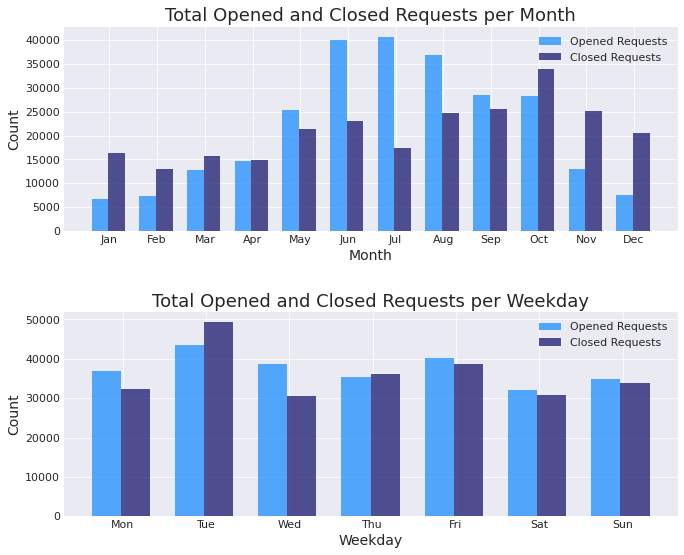

In [17]:
df_o_train_has_dupe['month'] = df_o_train_has_dupe.index.month
df_c_train_has_dupe['month'] = df_c_train_has_dupe.index.month
df_o_train_has_dupe['weekday'] = df_o_train_has_dupe.index.dayofweek
df_c_train_has_dupe['weekday'] = df_c_train_has_dupe.index.dayofweek

months = [
    'Jan', 
    'Feb', 
    'Mar', 
    'Apr', 
    'May', 
    'Jun', 
    'Jul', 
    'Aug', 
    'Sep',
    'Oct', 
    'Nov', 
    'Dec',
]
weekdays = [
    'Mon', 
    'Tue', 
    'Wed', 
    'Thu', 
    'Fri', 
    'Sat', 
    'Sun',
]

date_group = [['month', 1, 13, months], ['weekday', 0, 7, weekdays]]

fig, ax = plt.subplots(figsize=(11, 9))
fig.subplots_adjust(hspace=0.4)

for idx, d in enumerate(date_group):
    
    bar_width = 0.35
    x_open_pos = range(d[1], d[2])
    x_close_pos = [i + bar_width for i in x_open_pos]
    x_label_pos = [i + 0.2 for i in x_open_pos]
    
    y_open = df_o_train_has_dupe.groupby(d[0]).sum()['count']
    y_close = df_c_train_has_dupe.groupby(d[0]).sum()['count']

    ax = plt.subplot(2, 1, idx+1)
    ax.bar(x_open_pos, y_open, bar_width, color='C0', alpha=alpha_mpl)
    ax.bar(x_close_pos, y_close, bar_width, color='C2', alpha=alpha_mpl)

    ax.set_xticks(x_label_pos)
    ax.set_xticklabels(d[3])
    ax.set_xlabel(d[0].title())
    ax.set_ylabel('Count')
    ax.set_title('Total Opened and Closed Requests per {}'.format(d[0].title()))
    ax.legend(['Opened Requests', 'Closed Requests'])
    
plt.show();

There is a clear trend in opened and closed requests per month. The opened requests peak in the summer months. The closed requests rise to a small peak in the summer and a major peak in the fall. The requests per weekday plot displays less variation.

# Time Series

Plot various aspects of time series components, such as trends, seasonality and cycles. First plot the opened and closed requests across time.

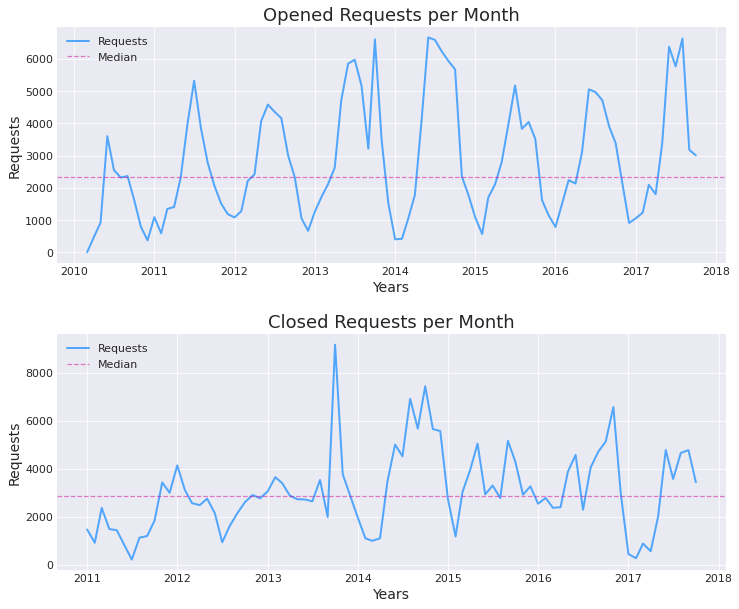

In [18]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.subplots_adjust(hspace=0.3)

for idx, df in enumerate(dfs):

    y = df[0]['count']
    x = df[0].index
    y_median = df[0]['count'].median()
    
    ax = plt.subplot(2, 1, idx+1)
    ax.plot(x, y, alpha=alpha_mpl, linewidth=2)
    ax.axhline(y_median, color='C1', alpha=0.5, linewidth=1.25,
               linestyle='--')

    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.set_xlabel('Years')
    ax.set_ylabel('Requests')
    ax.set_title('{} per Month'.format(df[1]))
    plt.legend(['Requests', 'Median', 'Trend Line'], loc='upper left')

plt.show();

Seasonality in the opened requests is clearly evident, with strong peaks mid-year at the height of summer. Seasonality in closed requests is less evident with a more random pattern to the data. Some opened requests outliers are possible in 2011, 2015 and 2016 where isolated spikes occur. Potential outliers for closed requests are located in the years 2013, 2014 and 2016.

Plot each year of opened and closed requests to visualize the general seasonal pattern to the data.

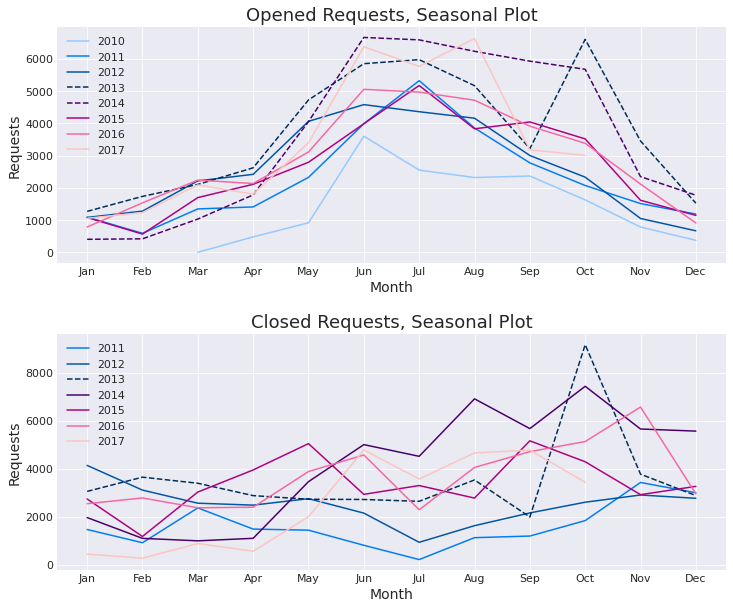

In [19]:
# Fill in missing dates in 2010 and 2018 with NaN to create the same x 
# axis length for all lines on the shared plot.
idx = pd.date_range('2010-01-01', '2017-12-01', freq='MS')
df_o_train_has_dupe = df_o_train_has_dupe.reindex(idx, fill_value=np.nan)

colors = [
    '#94caff', 
    '#007df6', 
    '#0055a7', 
    '#002d59', 
    '#49006a', 
    '#ae017e',
    '#f768a1', 
    '#fcc5c0',
]

fig, ax = plt.subplots(figsize=(12, 10))
fig.subplots_adjust(hspace=0.3)

for idx, df in enumerate(dfs):

    ax = plt.subplot(2, 1, idx+1)
    
    years = df[0].index.year.unique()
    x_label_pos = sorted(df[0].index.month.unique())

    if df[1] == 'Opened Requests':
        yr_highlight = [2013, 2014]
    else:
        yr_highlight = [2013]
    
    for idx, yr in enumerate(years):
        if df[1] == 'Closed Requests':
            # The opened and closed data start with different years;
            # coordinate the line colors so they are consistent across
            # plots.
            idx += 1
        if yr in yr_highlight:
            ls = '--'
        else:
            ls = '-'
        mask_year = df[0].index.year == yr
        x = df[0][mask_year].index.month
        y = df[0][mask_year]['count']
        ax.plot(x, y, color=colors[idx], linestyle=ls, label=yr)
    
    ax.set_xticks(x_label_pos)
    ax.set_xticklabels(months)
    ax.set_xlabel('Month')
    ax.set_ylabel('Requests')
    ax.set_title('{}, Seasonal Plot'.format(df[1]))
    ax.legend()

plt.show()

pass;

The yearly trends in the seasonal plot for opened requests follow a roughly similar pattern. The majority of the years start low in January and peak in the summer months. However, in 2013, there is a prominent spike in October, and in 2014, the volume remains high in September and October with a drop in November.

The seasonal plot for closed requests display a fair amount a variation across the years with a major spike in October 2013 that corresponds to the opened requests spike in 2013. 

Investigate the October 2013 spike in opened and closed requests. Is this spike caused by an increase in overall volume, a clearing of backlog requests or some other reason?

## Outliers

Do duplicates play a large role in the October 2013 spike?

In [20]:
spike_month = 10
spike_year = 2013

(
    df_tt[
        ((df_tt['creation_date_dt'].dt.month == spike_month) &
        (df_tt['creation_date_dt'].dt.year == spike_year)) |
        ((df_tt['completion_date_dt'].dt.month == spike_month) &
        (df_tt['completion_date_dt'].dt.year == spike_year))
    ]['is_duplicate']
    .value_counts()
)

False    10672
True        20
Name: is_duplicate, dtype: int64

Duplicates do not play a large role in the number of opened and closed requests in October 2013.

What is the ratio of opened to closed requests per month across the dataset? Is October 2013 an unusual ratio? Plot the ratios across time to visualize any unusual values, and plot the number opened and closed requests from September through November 2013 to visualize any abnormalities during that time period. 

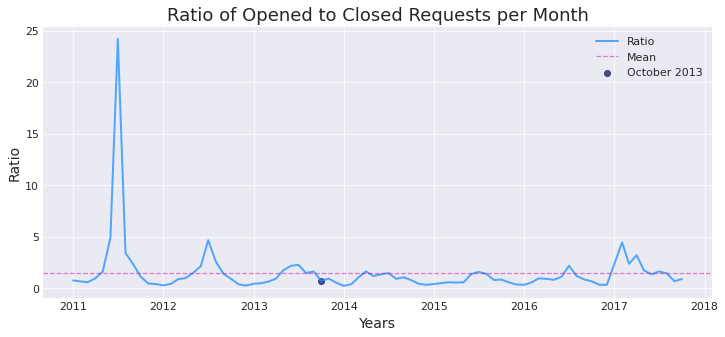

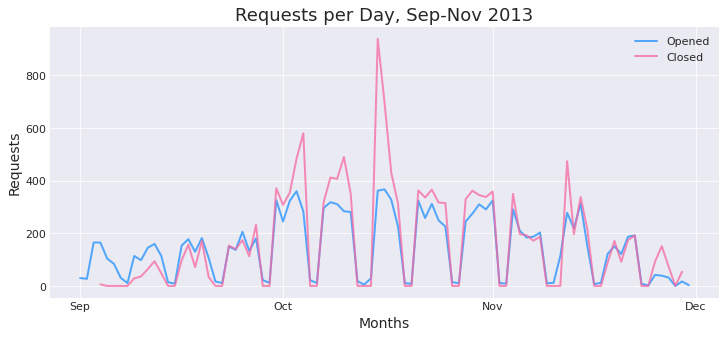

In [21]:
dfs_rename = [
    df_o_train_has_dupe.rename({'count': 'count_o'}, axis='columns'),
    df_c_train_has_dupe.rename({'count': 'count_c'}, axis='columns'),
]
df_ratio_o_c = (
    pd.concat(dfs_rename, axis='columns')
    .dropna()
    .drop(['month', 'weekday'], axis='columns').astype(int)
)
df_ratio_o_c['ratio'] = df_ratio_o_c['count_o'] / df_ratio_o_c['count_c']

y = df_ratio_o_c['ratio']
x = df_ratio_o_c.index
y_mean = df_ratio_o_c['ratio'].mean()
mask_spike = (
    (df_ratio_o_c.index.month == spike_month) &
    (df_ratio_o_c.index.year == spike_year)
)
y_oct_2013 = (df_ratio_o_c[mask_spike]['ratio'].values)

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(x, y, alpha=alpha_mpl, linewidth=2, label='Ratio')
ax.axhline(
    y_mean, 
    color='C1', 
    alpha=0.5, 
    linewidth=1.25, 
    linestyle='--',
    label='Mean',
)
ax.scatter(
    ['2013-10-01'], 
    y_oct_2013, 
    color='C2', 
    alpha=alpha_mpl,
    label='October 2013',
)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.set_xlabel('Years')
ax.set_ylabel('Ratio')
ax.set_title('Ratio of Opened to Closed Requests per Month')
ax.legend()

plt.show();

months_fall = [9, 10, 11]

mask_spike_o = (
    (df_tt['creation_date_dt'].dt.month.isin(months_fall)) &
    (df_tt['creation_date_dt'].dt.year == spike_year)
)
df_o_fall_2013 = (
    df_tt[mask_spike_o]
    .set_index('creation_date_dt')
    .groupby(pd.Grouper(freq='D'))
    .size()
    .to_frame('count')
)

mask_spike_c = (
    (df_tt['completion_date_dt'].dt.month.isin(months_fall)) &
    (df_tt['completion_date_dt'].dt.year == spike_year)
)
df_c_fall_2013 = (
    df_tt[mask_spike_c]
    .set_index('completion_date_dt')
    .groupby(pd.Grouper(freq='D'))
    .size()
    .to_frame('count')
)

y_o = df_o_fall_2013['count']
x_o = df_o_fall_2013.index
y_c = df_c_fall_2013['count']
x_c = df_c_fall_2013.index

fig, ax = plt.subplots(figsize=(12, 5))

ax.plot(x_o, y_o, alpha=alpha_mpl, linewidth=2, label='Opened')
ax.plot(
    x_c, 
    y_c, 
    color='#f768a1', 
    alpha=alpha_mpl, 
    linewidth=2,
    label='Closed',
)

ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
ax.set_xlabel('Months')
ax.set_ylabel('Requests')
ax.set_title('Requests per Day, Sep-Nov 2013')
ax.legend()

plt.show();

The ratio of opened to closed requests in October 2013 does not appear to be unusual for the dataset. However there does appear to be an increase in opened requests in October and a particular spike in closed requests relative to the month proceeding and following October. 

What is the Z-Score of the ratio of opened to closed requests for October 2013?

In [22]:
print(
    'Ratio of opened to closed requests for October 2013: {}'
    .format(y_oct_2013[0])
)
s_ratio = df_ratio_o_c['ratio'].describe()
ratio_mean = s_ratio.get('mean')
ratio_std = s_ratio.get('std')
oct_2013_std = (y_oct_2013[0] - ratio_mean) / ratio_std
print('Oct 2013 Z-Score: {}'.format(oct_2013_std))

Ratio of opened to closed requests for October 2013: 0.7210876924757017
Oct 2013 Z-Score: -0.2790973842228402


The Z-Score for opened to closed requests for October 2013 is within one standard deviation from the mean, so it's not unusual for this dataset. 

How many requests are opened and closed within the same month?

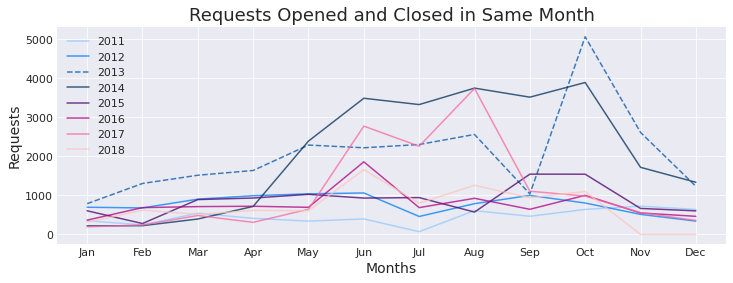

In [23]:
df_same_month = df_tt[['creation_date_dt', 'completion_date_dt']].copy()

mask_same_month = (
    (df_same_month['creation_date_dt'].dt.month == df_same_month['completion_date_dt'].dt.month) &
    (df_same_month['creation_date_dt'].dt.year == df_same_month['completion_date_dt'].dt.year)
)

df_same_month['same_month'] = np.where(mask_same_month, True, False)
df_same_month = df_same_month[df_same_month['same_month']]
group_year_month = [
    df_same_month['completion_date_dt'].dt.year,
    df_same_month['completion_date_dt'].dt.month
]
df_same_month = (
    df_same_month.groupby(group_year_month)
    .size()
    .to_frame('count')
)

m_index = pd.MultiIndex(
    levels=[[2018], [11, 12]],
    codes=[[0, 0], [0, 1]],
    names=['completion_date_dt', 'completion_date_dt']
)
df_same_month = df_same_month.append(
    pd.DataFrame([0, 0], index=m_index, columns=['count'])
)

x = range(1, 13, 1)
y = df_same_month['count']

years = df_same_month.index.get_level_values(0).unique()

fig, ax = plt.subplots(figsize=(12, 4))

for idx, yr in enumerate(years):
    if yr in [2013]:
        ls = '--'
    else:
        ls = '-'
    y = df_same_month.loc[yr]['count']
    ax.plot(x, y, color=colors[idx], alpha=0.75, linestyle=ls, label=yr)

ax.set_xticks(x)
ax.set_xticklabels(months)
ax.set_xlabel('Months')
ax.set_ylabel('Requests')
ax.set_title('Requests Opened and Closed in Same Month')
ax.legend()

plt.show();

There is a high volume of requests that are both opened and closed in October 2013. It's possible that this spike was caused a weather event that caused damage to trees, such as a strong storm with high winds. Pairing this tree trims dataset with weather data could lend further insight into the October 2013 spike, but doing so is out of scope for this analysis. The spike appears to be a valid outlier created by a legitimate increase in request volume. 

## Decomposition

Use classical decomposition to review trends and seasonality to verify the data is suitable for time series forecasting. Use additive model as the seasonal variation is relative stable over time and the trend is linear.

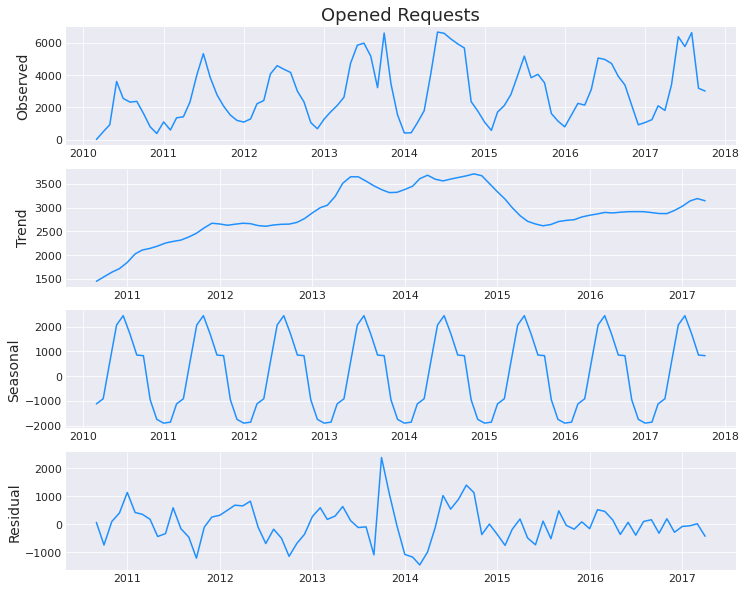

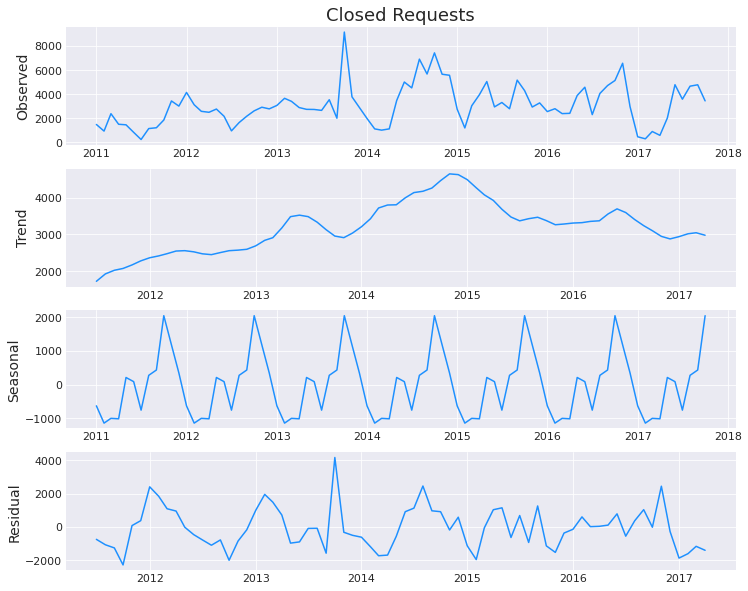

In [24]:
line_width = 1.5

for idx, df in enumerate(dfs):
    decomp = sm.tsa.seasonal_decompose(
        df[0]['count'],
        model='additive',
        period=12,
    )

    fig, (ax0, ax1, ax2, ax3) = plt.subplots(
        nrows=4, 
        ncols=1, 
        figsize=(12, 10)
    )
    
    ax0.plot(decomp.observed, linewidth=line_width)
    ax0.set_ylabel('Observed')
    ax0.set_title('{}'.format(df[1]))

    ax1.plot(decomp.trend, linewidth=line_width)
    ax1.set_ylabel('Trend')

    ax2.plot(decomp.seasonal, linewidth=line_width)
    ax2.set_ylabel('Seasonal')

    ax3.plot(decomp.resid, linewidth=line_width)
    ax3.set_ylabel('Residual')

    plt.show();
    
pass;

The plots indicate a strong seasonal pattern in the data for both the opened requests and closed requests. The trend for both dataset follow a generally similar rising and falling path that peaks at the end of 2015. The plots indicate that the data is non-stationary, meaning the data exhibits trend and/or seasonality characteristics. 

# Conclusions

When grouped by month, the opened requests and closed requests variables do not appear to be linearly related, and the data exhibits trend and seasonality characteristics. Applying the Seasonal Autoregressive Integrated Moving Average (ARIMA) model to both opened requests and closed requests would be appropriate.